In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as kr
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [2]:
img_height = 180
img_width = 180
batch_size = 32

train_ds = kr.utils.image_dataset_from_directory(
    "Covid19-dataset/train",
    seed = 753,
    image_size = (img_height,img_width)
)
test_ds = kr.utils.image_dataset_from_directory(
    "Covid19-dataset/test",
    seed = 753,
    image_size = (img_height,img_width)
)


class_names = test_ds.class_names

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [3]:
def count(counts, batch):
  features, labels = batch
  class_1 = (labels == 1)
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = (labels == 0)
  class_0 = tf.cast(class_0, tf.int32)

  class_2 = (labels == 2)
  class_2 = tf.cast(class_0, tf.int32)
  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)
  counts['class_2'] += tf.reduce_sum(class_2)

  return counts

counts = train_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0, 'class_2' : 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy(),
                   counts['class_2']]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)


[0.380137   0.23972602 0.380137  ]


In [4]:
def class_func(features, label):
  return label

In [5]:
resample_ds = (
    train_ds
    .unbatch()
    .rejection_resample(class_func, target_dist=[0.33,0.33,0.33],
                        initial_dist=fractions)
    .batch(32))

balanced_train_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = balanced_train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [6]:
base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_height,img_width,3),
    pooling="max",
    classes=3,
    classifier_activation="softmax"
)

base_model.trainable = False

80134624/80134624 [==============================] - 2s 0us/step


In [7]:
mean = np.array([127.5]*3)
var = mean ** 2
norm_layer = kr.layers.experimental.preprocessing.Normalization(mean=mean,variance=var)

data_augmentation = kr.Sequential(
  [
    kr.layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
    kr.layers.RandomRotation(0.3),
    kr.layers.RandomZoom(-0.1),
    kr.layers.RandomHeight(0.1),
    kr.layers.RandomWidth(0.1)
  ]
)

In [8]:
inputs = kr.Input(shape=(180,180,3))
mean = np.array([127.5]*3)
var = mean ** 2


norm_layer = kr.layers.experimental.preprocessing.Normalization(mean=mean,variance=var)
x = norm_layer(inputs)

x = base_model(x)

x = kr.layers.Dense(256)(x)
x = kr.layers.Dense(64)(x)
output = kr.layers.Dense(3, activation="softmax")(x)
model_fin = kr.Model(inputs,output)

In [9]:
model_fin.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 normalization_1 (Normaliza  (None, 180, 180, 3)       0         
 tion)                                                           
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                             

In [10]:
optimzer = kr.optimizers.Adam(learning_rate=0.000001)
model_fin.compile(
    optimizer="Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [11]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=2)
#checkpoint = ModelCheckpoint('model/vgg16_best.tf', monitor='acc', verbose=1, mode='max',save_best_only=True)

In [12]:
history = model_fin.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks = [early_stop],
    shuffle = False,
)

Epoch 1/5


Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.380137][0 1 0]
Proportion of examples rejected by sampler is high: [0.760274][0.380137 0.239726022 0.38013

10/10 [==============================] - 84s 8s/step - loss: 2.1626 - accuracy: 0.4241 - val_loss: 1.6054 - val_accuracy: 0.3939
Epoch 2/5
10/10 [==============================] - 77s 8s/step - loss: 1.0272 - accuracy: 0.6034 - val_loss: 0.3969 - val_accuracy: 0.8636
Epoch 3/5
10/10 [==============================] - 76s 8s/step - loss: 0.3857 - accuracy: 0.8517 - val_loss: 0.2183 - val_accuracy: 0.9545
Epoch 4/5
10/10 [==============================] - 76s 8s/step - loss: 0.2820 - accuracy: 0.8897 - val_loss: 0.1989 - val_accuracy: 0.9545
Epoch 5/5
10/10 [==============================] - 77s 8s/step - loss: 0.1693 - accuracy: 0.9414 - val_loss: 0.1724 - val_accuracy: 0.9545


In [13]:
val_images = [[d[0][:]/255,d[1]] for d in val_ds.unbatch().as_numpy_iterator()]

Text(0.5, 1.0, '1')

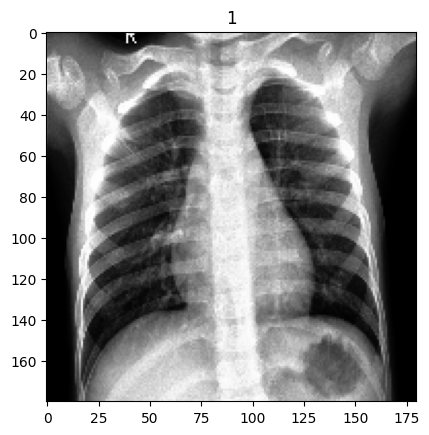

In [14]:
x=10

plt.imshow(val_images[x][0])
plt.title(val_images[x][1])

In [15]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
                 val_images[x][0], 
                model_fin.predict,test_ds.class_names)



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


In [16]:
print("kkk")

kkk


In [17]:
image, mask = explanation.get_image_and_mask(1, False)

(-0.5, 179.5, 179.5, -0.5)

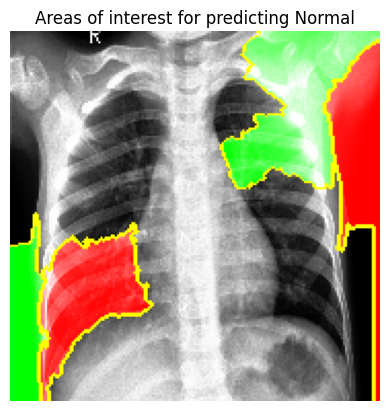

In [18]:
plt.imshow(mark_boundaries(image,mask))
plt.title("Areas of interest for predicting Normal")
plt.axis("off")

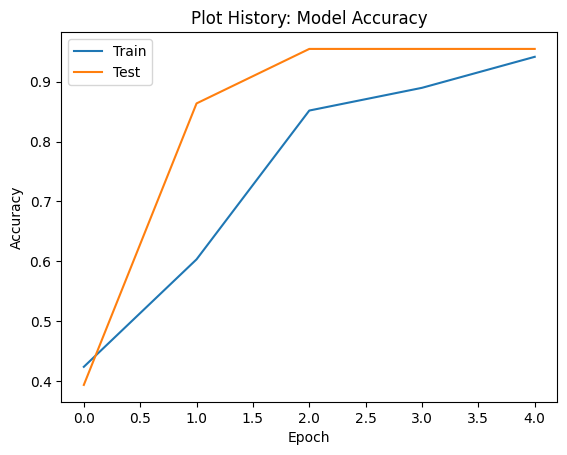

In [19]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Plot History: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

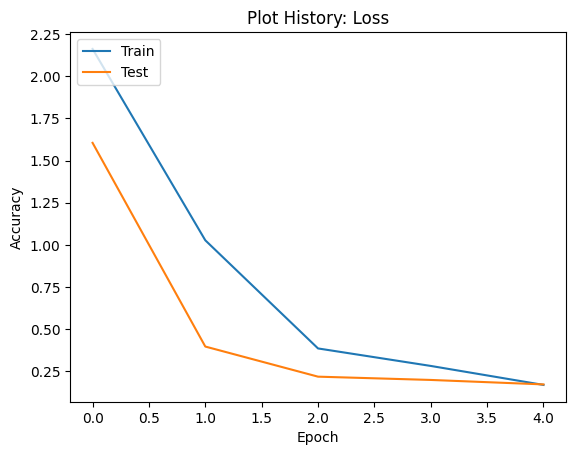

In [20]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Plot History: Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
y_pred = np.argmax(model_fin.predict(val_ds),axis=1)

train_label = np.concatenate([y for x, y in val_ds], axis=0)
test_label = np.concatenate([y for x, y in val_ds], axis=0) 
CM = tf.math.confusion_matrix(labels=test_label,predictions=y_pred).numpy()

3/3 [==============================] - 14s 4s/step


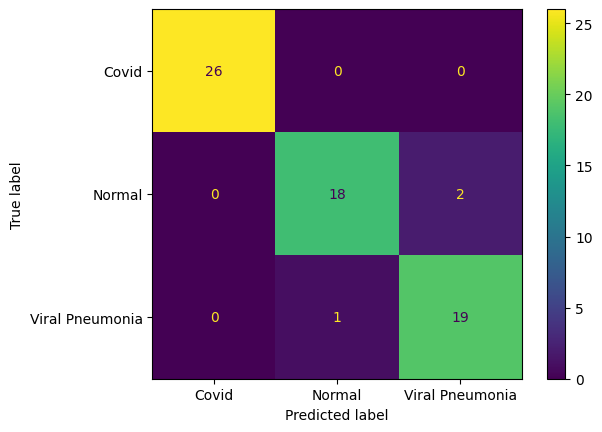

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cd = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = class_names)
cd.plot()
plt.show()

In [23]:
print(f"Precision {class_names[0]} : {CM[0,0]/CM[0].sum()}")
print(f"Precision {class_names[1]} : {CM[1,1]/CM[1].sum()}")
print(f"Precision {class_names[2]} : {CM[2,2]/CM[2].sum()}")

print(f"Recall {class_names[0]} : {CM[0,0]/CM[:,0].sum()}")
print(f"Recall {class_names[1]} : {CM[1,1]/CM[:,1].sum()}")
print(f"Recall {class_names[2]} : {CM[2,2]/CM[:,2].sum()}")


Precision Covid : 1.0
Precision Normal : 0.9
Precision Viral Pneumonia : 0.95
Recall Covid : 1.0
Recall Normal : 0.9473684210526315
Recall Viral Pneumonia : 0.9047619047619048
